# Pricing Elasticity of Demand Modeling

Pricing Elasticity of Demand (PED) is a measure of how responsive demand (or quantity sold) is to price change. When demand (y-axis) is plotted against price (x-axis), a demand curve is drawn. From the demand curve, we can compute the PED using pairs of points or at a particular point. Typically, elasticity changes along every point (or between every pair of points) on the demand curve. When we assume that elasticity remains constant along the demand curve, we can use regression techniques to estimate the constant elasticity. Let's take a look to see how regression is used to estimate the constant elasticity.

## Load data

This data is taken from [Kaggle](https://www.kaggle.com/datasets/suddharshan/retail-price-optimization?datasetId=1865343).

In [1]:
import pandas as pd
import numpy as np

def get_text(r):
    product_category_name = r['product_category_name']
    

df = pd.read_csv('./data/retail_price.csv') \
    .assign(
        month_year=lambda d: pd.to_datetime(d['month_year']),
        year=lambda d: d['month_year'].dt.year,
        month=lambda d: d['month_year'].dt.month,
        weekend=lambda d: d['weekday'].apply(lambda x: 1 if x >= 5 else 0),
        text=lambda d: d['product_category_name'].apply(lambda s: ' '.join(s.split('_')))
    )
df.shape

(676, 31)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   product_id                  676 non-null    object        
 1   product_category_name       676 non-null    object        
 2   month_year                  676 non-null    datetime64[ns]
 3   qty                         676 non-null    int64         
 4   total_price                 676 non-null    float64       
 5   freight_price               676 non-null    float64       
 6   unit_price                  676 non-null    float64       
 7   product_name_lenght         676 non-null    int64         
 8   product_description_lenght  676 non-null    int64         
 9   product_photos_qty          676 non-null    int64         
 10  product_weight_g            676 non-null    int64         
 11  product_score               676 non-null    float64       

## Visualize pricing elasticity of demand

There's already a lot of exploratory data analysis (EDA) and visualization on the data on Kaggle, and so we will not plot too much. Below, we are demand (quantity) versus price over all products. You can see that there tends to be a downward slope. Also note, we take the log of the demand and price.

<Axes: xlabel='unit_price', ylabel='qty'>

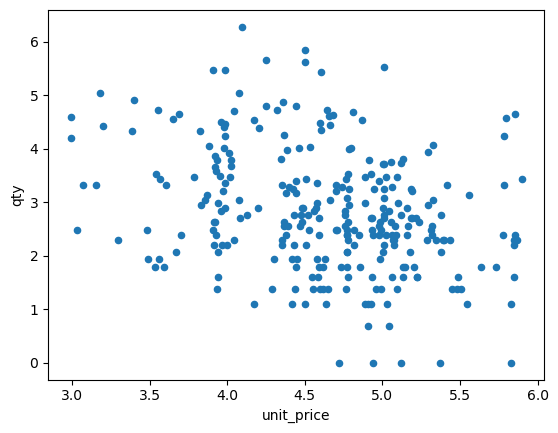

In [3]:
df[['unit_price', 'qty']] \
    .groupby(['unit_price']) \
    .sum() \
    .reset_index() \
    .assign(
        unit_price=lambda d: np.log(d['unit_price']),
        qty=lambda d: np.log(d['qty'])
    ) \
    .plot(kind='scatter', x='unit_price', y='qty')

## Split into training/testing

It seems that there is data in 2017 for January and also in 2018 for January. Let's use the 2017 data for training and the 2018 data for testing/validation.

In [4]:
df['month_year'].value_counts().sort_index()

month_year
2017-01-01     2
2017-01-02     9
2017-01-03    13
2017-01-04    15
2017-01-05    20
2017-01-06    25
2017-01-07    33
2017-01-08    37
2017-01-09    36
2017-01-10    43
2017-01-11    44
2017-01-12    44
2018-01-01    48
2018-01-02    49
2018-01-03    50
2018-01-04    48
2018-01-05    40
2018-01-06    42
2018-01-07    40
2018-01-08    38
Name: count, dtype: int64

In [5]:
df_tr = df[df['month_year'] <= '2017-12-31']
df_te = df[df['month_year'] >= '2018-01-01']

df_tr.shape, df_te.shape

((321, 31), (355, 31))

## Simple log-log model

An easy way to model the relationship between price and quantity is using log-log regression. Note that the coefficient associated with price is the estimated constant elasticity. 

$\log{Q} \sim \log{P}$

In [6]:
Xy_tr = df_tr.groupby(['unit_price']) \
    .agg(qty_sum=pd.NamedAgg(column='qty', aggfunc='sum')) \
    .assign(qty_sum=lambda d: np.log(d['qty_sum'])) \
    .reset_index() \
    .assign(unit_price=lambda d: np.log(d['unit_price']))

Xy_te = df_te.groupby(['unit_price']) \
    .agg(qty_sum=pd.NamedAgg(column='qty', aggfunc='sum')) \
    .assign(qty_sum=lambda d: np.log(d['qty_sum'])) \
    .reset_index() \
    .assign(unit_price=lambda d: np.log(d['unit_price']))

X_tr = Xy_tr[['unit_price']]
X_te = Xy_te[['unit_price']]

y_tr = Xy_tr['qty_sum']
y_te = Xy_te['qty_sum']

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((128, 1), (181, 1), (128,), (181,))

Since we want to have fun and suspect that quantity and price may have linear or non-linear relationships, we will try out a few regression models. 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

def get_performance(y_tr, z_tr, y_te, z_te):
    y_tr = np.exp(y_tr)
    z_tr = np.exp(z_tr)
    
    y_te = np.exp(y_te)
    z_te = np.exp(z_te)
    
    mae_tr = mean_absolute_error(y_tr, z_tr)
    mae_te = mean_absolute_error(y_te, z_te)
    
    mape_tr = np.mean(np.abs(y_tr - z_tr) / y_tr)
    mape_te = np.mean(np.abs(y_te - z_te) / y_te)
    
    wmape_tr = np.abs(y_tr - z_tr).sum() / y_tr.sum()
    wmape_te = np.abs(y_te - z_te).sum() / y_te.sum()
    
    s = pd.Series([
        mae_tr,
        mae_te,
        mape_tr,
        mape_te,
        wmape_tr,
        wmape_te,
        mae_tr / (y_tr.max() - y_tr.min()), 
        mae_te / (y_te.max() - y_te.min()),
        mae_tr / y_tr.std(), 
        mae_te / y_te.std(),
        mae_tr / y_tr.mean(), 
        mae_te / y_te.mean()
    ], index=['mae_tr', 'mae_te', 
              'mape_tr', 'mape_te', 
              'wmape_tr', 'wmape_te', 
              'range_mae_tr', 'range_mae_te', 
              'std_mae_tr', 'std_mae_te', 
              'mean_mae_tr', 'mean_mae_te'])
    
    return s

models = [
    LinearRegression(),
    RandomForestRegressor(n_jobs=-1, random_state=37, n_estimators=25),
    LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=50, max_depth=2)
]

for m in models:
    m.fit(X_tr, y_tr)
    
pd.DataFrame([get_performance(y_tr, m.predict(X_tr), y_te, m.predict(X_te)) 
              for m in models], index=['OLS', 'RF', 'GBT'])

AttributeError: module 'pandas.core.strings' has no attribute 'StringMethods'

GBT seems to have the lowest validated MAE at 22.9.

In [ ]:
simple_loglog_lr, simple_loglog_rf, simple_loglog_gb = models

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': X_tr['unit_price'].values,
    'q_true': y_tr.values,
    'q_lr': simple_loglog_lr.predict(X_tr),
    'q_rf': simple_loglog_rf.predict(X_tr),
    'q_gb': simple_loglog_gb.predict(X_tr)
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': X_te['unit_price'].values,
    'q_true': y_te.values,
    'q_lr': simple_loglog_lr.predict(X_te),
    'q_rf': simple_loglog_rf.predict(X_te),
    'q_gb': simple_loglog_gb.predict(X_te)
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='r')
_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='b')

_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='r')
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='b')

_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='r')
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='b')

_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='r')
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='b')

fig.tight_layout()

## Log-log model with features

$\log{Q} \sim \log{P} + X_1 + X_2 + \ldots + X_n$

In [ ]:
def get_Xy(df):
    a = df.groupby(['product_category_name', 'unit_price']) \
        .agg(qty_sum=pd.NamedAgg(column='qty', aggfunc='sum')) \
        .assign(qty_sum=lambda d: np.log(d['qty_sum'])) \
        .rename(columns={'qty_sum': 'quantity'})
    
    b = df.groupby(['product_category_name', 'unit_price']) \
        .agg(
            freight_price=pd.NamedAgg(column='freight_price', aggfunc='mean'),
            product_score=pd.NamedAgg(column='product_score', aggfunc='mean'),
            weekday=pd.NamedAgg(column='weekday', aggfunc='mean'),
            holiday=pd.NamedAgg(column='holiday', aggfunc='mean'),
            customers=pd.NamedAgg(column='customers', aggfunc='mean'),
            volume=pd.NamedAgg(column='volume', aggfunc='mean'),
            s=pd.NamedAgg(column='s', aggfunc='mean'),
            comp_1=pd.NamedAgg(column='comp_1', aggfunc='mean'),
            ps1=pd.NamedAgg(column='ps1', aggfunc='mean'),
            fp1=pd.NamedAgg(column='fp1', aggfunc='mean'),
            comp_2=pd.NamedAgg(column='comp_2', aggfunc='mean'),
            ps2=pd.NamedAgg(column='ps2', aggfunc='mean'),
            fp2=pd.NamedAgg(column='fp2', aggfunc='mean'),
            comp_3=pd.NamedAgg(column='comp_3', aggfunc='mean'),
            ps3=pd.NamedAgg(column='ps3', aggfunc='mean'),
            fp3=pd.NamedAgg(column='fp3', aggfunc='mean'),
            lag_price=pd.NamedAgg(column='lag_price', aggfunc='mean')
        )
    
    Xy = a \
        .join(b, how='left') \
        .reset_index() \
        .assign(unit_price=lambda d: np.log(d['unit_price']))
    
    c = pd.get_dummies(Xy[['product_category_name']]).iloc[:,1:]
    
    Xy = Xy.join(c, how='left').drop(columns=['product_category_name'])
    
    X = Xy[Xy.columns.drop(['quantity'])]
    y = Xy['quantity']
    
    return X, y

X_tr, y_tr = get_Xy(df_tr)
X_te, y_te = get_Xy(df_te)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

In [ ]:
models = [
    LinearRegression(),
    RandomForestRegressor(n_jobs=-1, random_state=37, n_estimators=25),
    LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=50, max_depth=2)
]

for m in models:
    m.fit(X_tr, y_tr)
    
pd.DataFrame([get_performance(y_tr, m.predict(X_tr), y_te, m.predict(X_te)) 
              for m in models], index=['OLS', 'RF', 'GBT'])

In [ ]:
features_loglog_lr, features_loglog_rf, features_loglog_gb = models

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': X_tr['unit_price'].values,
    'q_true': y_tr.values,
    'q_lr': features_loglog_lr.predict(X_tr),
    'q_rf': features_loglog_rf.predict(X_tr),
    'q_gb': features_loglog_gb.predict(X_tr)
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': X_te['unit_price'].values,
    'q_true': y_te.values,
    'q_lr': features_loglog_lr.predict(X_te),
    'q_rf': features_loglog_rf.predict(X_te),
    'q_gb': features_loglog_gb.predict(X_te)
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0])
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1])
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2])
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='r')
_df2.plot(kind='scatter', x='q_true', y='p', ax=ax[0], color='b')

_df1.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='r')
_df2.plot(kind='scatter', x='q_lr', y='p', ax=ax[1], color='b')

_df1.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='r')
_df2.plot(kind='scatter', x='q_rf', y='p', ax=ax[2], color='b')

_df1.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='r')
_df2.plot(kind='scatter', x='q_gb', y='p', ax=ax[3], color='b')

fig.tight_layout()

## MERF model

$y_i = f(X_i) + Z_i u_i + e_i$

In [ ]:
p2i = {c: i for i, c in enumerate(list(df['product_category_name'].unique()))}
i2p = {v: k for k, v in p2i.items()}

p2i

In [ ]:
def get_Xy(df):
    a = df.groupby(['product_id', 'product_category_name', 'unit_price']) \
        .agg(
            qty_sum=pd.NamedAgg(column='qty', aggfunc='sum'),
            freight_price=pd.NamedAgg(column='freight_price', aggfunc='mean'),
            product_score=pd.NamedAgg(column='product_score', aggfunc='mean'),
            comp_1=pd.NamedAgg(column='comp_1', aggfunc='mean'),
            ps1=pd.NamedAgg(column='ps1', aggfunc='mean'),
            fp1=pd.NamedAgg(column='fp1', aggfunc='mean'),
            comp_2=pd.NamedAgg(column='comp_2', aggfunc='mean'),
            ps2=pd.NamedAgg(column='ps2', aggfunc='mean'),
            fp2=pd.NamedAgg(column='fp2', aggfunc='mean'),
            comp_3=pd.NamedAgg(column='comp_3', aggfunc='mean'),
            ps3=pd.NamedAgg(column='ps3', aggfunc='mean'),
            fp3=pd.NamedAgg(column='fp3', aggfunc='mean'),
            lag_price=pd.NamedAgg(column='lag_price', aggfunc='mean')
        ) \
        .assign(
            qty_sum=lambda d: np.log(d['qty_sum'])
        ) \
        .rename(columns={'qty_sum': 'quantity'}) \
        .reset_index() \
        .drop(columns=['product_id']) \
        .set_index(['product_category_name', 'unit_price'])
    
    b = df.groupby(['product_category_name', 'unit_price']) \
        .agg(
            weekday=pd.NamedAgg(column='weekday', aggfunc='mean'),
            holiday=pd.NamedAgg(column='holiday', aggfunc='mean'),
            customers=pd.NamedAgg(column='customers', aggfunc='mean'),
            volume=pd.NamedAgg(column='volume', aggfunc='mean'),
            s=pd.NamedAgg(column='s', aggfunc='mean')
        )
    
    Xy = a \
        .join(b, how='inner') \
        .reset_index() \
        .assign(unit_price=lambda d: np.log(d['unit_price']))
    
    Xy = Xy.assign(product_category_name=lambda d: d['product_category_name'].map(p2i))
    
    X = Xy[Xy.columns.drop(['quantity', 'product_category_name', 'weekday', 'holiday', 'customers', 'volume', 's'])]
    Z = Xy[['weekday', 'holiday', 'customers', 's', 'lag_price']]
    C = Xy['product_category_name']
    y = Xy['quantity']
    
    return X, Z, C, y

X_tr, Z_tr, C_tr, y_tr = get_Xy(df_tr)
X_te, Z_te, C_te, y_te = get_Xy(df_te)

In [ ]:
X_tr.shape, Z_tr.shape, C_tr.shape, y_tr.shape

In [ ]:
X_te.shape, Z_te.shape, C_te.shape, y_te.shape

In [ ]:
from merf import MERF

merf = MERF(
    fixed_effects_model=LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=25, max_depth=2),
    max_iterations=30
)
merf.fit(X_tr, Z_tr, C_tr, y_tr)
get_performance(y_tr, merf.predict(X_tr, Z_tr, C_tr), y_te, merf.predict(X_te, Z_te, C_te))

In [ ]:
pd.Series(merf.fe_model.feature_importances_, X_tr.columns) \
    .sort_values(ascending=False)

In [ ]:
merf.trained_b.sort_index() \
    .rename(columns={0: 'weekday', 1: 'holiday', 2: 'customers', 3: 'volume', 4: 's', 5: 'lag_price'}) \
    .T \
    .rename(columns=i2p).T

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': X_tr['unit_price'].values,
    'q_true': y_tr.values,
    'q_pred': merf.predict(X_tr, Z_tr, C_tr)
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax, color='r')
_df1.plot(kind='scatter', x='q_pred', y='p', ax=ax, color='b')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': X_te['unit_price'].values,
    'q_true': y_te.values,
    'q_pred': merf.predict(X_te, Z_te, C_te)
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax, color='r')
_df2.plot(kind='scatter', x='q_pred', y='p', ax=ax, color='b')

fig.tight_layout()

In [ ]:
p2i = {c: i for i, c in enumerate(list(df['product_id'].unique()))}
i2p = {v: k for k, v in p2i.items()}

p2i

In [ ]:
c2i = {c: i for i, c in enumerate(list(df['product_category_name'].unique()))}
i2c = {v: k for k, v in p2i.items()}

c2i

In [ ]:
c2i.keys()

In [ ]:
def get_Xy(df):
    a = df.groupby(['product_id', 'product_category_name', 'unit_price']) \
        .agg(
            qty_sum=pd.NamedAgg(column='qty', aggfunc='sum'),
            freight_price=pd.NamedAgg(column='freight_price', aggfunc='mean'),
            product_score=pd.NamedAgg(column='product_score', aggfunc='mean'),
            comp_1=pd.NamedAgg(column='comp_1', aggfunc='mean'),
            ps1=pd.NamedAgg(column='ps1', aggfunc='mean'),
            fp1=pd.NamedAgg(column='fp1', aggfunc='mean'),
            comp_2=pd.NamedAgg(column='comp_2', aggfunc='mean'),
            ps2=pd.NamedAgg(column='ps2', aggfunc='mean'),
            fp2=pd.NamedAgg(column='fp2', aggfunc='mean'),
            comp_3=pd.NamedAgg(column='comp_3', aggfunc='mean'),
            ps3=pd.NamedAgg(column='ps3', aggfunc='mean'),
            fp3=pd.NamedAgg(column='fp3', aggfunc='mean'),
            lag_price=pd.NamedAgg(column='lag_price', aggfunc='mean')
        ) \
        .assign(
            qty_sum=lambda d: np.log(d['qty_sum'])
        ) \
        .rename(columns={'qty_sum': 'quantity'}) \
        .reset_index() \
        .assign(
            bed1=lambda d: np.where(d['product_id']=='bed1', 1, 0),
            garden5=lambda d: np.where(d['product_id']=='garden5', 1, 0),
            consoles1=lambda d: np.where(d['product_id']=='consoles1', 1, 0),
            garden7=lambda d: np.where(d['product_id']=='garden7', 1, 0),
            health9=lambda d: np.where(d['product_id']=='health9', 1, 0),
            cool4=lambda d: np.where(d['product_id']=='cool4', 1, 0),
            health3=lambda d: np.where(d['product_id']=='health3', 1, 0),
            perfumery1=lambda d: np.where(d['product_id']=='perfumery1', 1, 0),
            cool5=lambda d: np.where(d['product_id']=='cool5', 1, 0),
            health8=lambda d: np.where(d['product_id']=='health8', 1, 0),
            garden4=lambda d: np.where(d['product_id']=='garden4', 1, 0),
            computers5=lambda d: np.where(d['product_id']=='computers5', 1, 0),
            garden10=lambda d: np.where(d['product_id']=='garden10', 1, 0),
            computers6=lambda d: np.where(d['product_id']=='computers6', 1, 0),
            health6=lambda d: np.where(d['product_id']=='health6', 1, 0),
            garden6=lambda d: np.where(d['product_id']=='garden6', 1, 0),
            health10=lambda d: np.where(d['product_id']=='health10', 1, 0),
            watches2=lambda d: np.where(d['product_id']=='watches2', 1, 0),
            health1=lambda d: np.where(d['product_id']=='health1', 1, 0),
            garden8=lambda d: np.where(d['product_id']=='garden8', 1, 0),
            garden9=lambda d: np.where(d['product_id']=='garden9', 1, 0),
            watches6=lambda d: np.where(d['product_id']=='watches6', 1, 0),
            cool3=lambda d: np.where(d['product_id']=='cool3', 1, 0),
            perfumery2=lambda d: np.where(d['product_id']=='perfumery2', 1, 0),
            cool2=lambda d: np.where(d['product_id']=='cool2', 1, 0),
            computers1=lambda d: np.where(d['product_id']=='computers1', 1, 0),
            consoles2=lambda d: np.where(d['product_id']=='consoles2', 1, 0),
            health5=lambda d: np.where(d['product_id']=='health5', 1, 0),
            watches8=lambda d: np.where(d['product_id']=='watches8', 1, 0),
            furniture4=lambda d: np.where(d['product_id']=='furniture4', 1, 0),
            watches5=lambda d: np.where(d['product_id']=='watches5', 1, 0),
            health7=lambda d: np.where(d['product_id']=='health7', 1, 0),
            bed3=lambda d: np.where(d['product_id']=='bed3', 1, 0),
            garden3=lambda d: np.where(d['product_id']=='garden3', 1, 0),
            bed2=lambda d: np.where(d['product_id']=='bed2', 1, 0),
            furniture3=lambda d: np.where(d['product_id']=='furniture3', 1, 0),
            watches4=lambda d: np.where(d['product_id']=='watches4', 1, 0),
            watches3=lambda d: np.where(d['product_id']=='watches3', 1, 0),
            furniture2=lambda d: np.where(d['product_id']=='furniture2', 1, 0),
            garden2=lambda d: np.where(d['product_id']=='garden2', 1, 0),
            furniture1=lambda d: np.where(d['product_id']=='furniture1', 1, 0),
            health2=lambda d: np.where(d['product_id']=='health2', 1, 0),
            garden1=lambda d: np.where(d['product_id']=='garden1', 1, 0),
            cool1=lambda d: np.where(d['product_id']=='cool1', 1, 0),
            computers4=lambda d: np.where(d['product_id']=='computers4', 1, 0),
            watches7=lambda d: np.where(d['product_id']=='watches7', 1, 0),
            computers3=lambda d: np.where(d['product_id']=='computers3', 1, 0),
            health4=lambda d: np.where(d['product_id']=='health4', 1, 0),
            watches1=lambda d: np.where(d['product_id']=='watches1', 1, 0),
            computers2=lambda d: np.where(d['product_id']=='computers2', 1, 0),
            bed4=lambda d: np.where(d['product_id']=='bed4', 1, 0),
            bed5=lambda d: np.where(d['product_id']=='bed5', 1, 0)
        ) \
        .drop(columns=['product_id']) \
        .set_index(['product_category_name', 'unit_price'])
    
    b = df.groupby(['product_category_name', 'unit_price']) \
        .agg(
            weekday=pd.NamedAgg(column='weekday', aggfunc='mean'),
            holiday=pd.NamedAgg(column='holiday', aggfunc='mean'),
            customers=pd.NamedAgg(column='customers', aggfunc='mean'),
            volume=pd.NamedAgg(column='volume', aggfunc='mean'),
            s=pd.NamedAgg(column='s', aggfunc='mean')
        ) \
        .reset_index() \
        .assign(
            bed_bath_table=lambda d: np.where(d['product_category_name']=='bed_bath_table', 1, 0),
            garden_tools=lambda d: np.where(d['product_category_name']=='garden_tools', 1, 0),
            consoles_games=lambda d: np.where(d['product_category_name']=='consoles_games', 1, 0),
            health_beauty=lambda d: np.where(d['product_category_name']=='health_beauty', 1, 0),
            cool_stuff=lambda d: np.where(d['product_category_name']=='cool_stuff', 1, 0),
            perfumery=lambda d: np.where(d['product_category_name']=='perfumery', 1, 0),
            computers_accessories=lambda d: np.where(d['product_category_name']=='computers_accessories', 1, 0),
            watches_gifts=lambda d: np.where(d['product_category_name']=='watches_gifts', 1, 0),
            furniture_decor=lambda d: np.where(d['product_category_name']=='furniture_decor', 1, 0)
        ) \
        .set_index(['product_category_name', 'unit_price'])
    
    Xy = a \
        .join(b, how='inner') \
        .reset_index() \
        .assign(unit_price=lambda d: np.log(d['unit_price']))
    
    Xy = Xy.assign(product_category_name=lambda d: d['product_category_name'].map(c2i)) \
        .query('unit_price < 5.7') \
        .query('quantity < 4.3')
    
    X = Xy[Xy.columns.drop(['quantity', 'product_category_name', 'bed_bath_table', 'garden_tools', 'consoles_games', 'health_beauty', 'cool_stuff', 'perfumery', 'computers_accessories', 'watches_gifts', 'furniture_decor', 'weekday', 'holiday', 'customers', 'volume', 's'])]
    Z = Xy[['bed_bath_table', 'garden_tools', 'consoles_games', 'health_beauty', 'cool_stuff', 'perfumery', 'computers_accessories', 'watches_gifts', 'furniture_decor', 'weekday', 'holiday', 'customers', 's']]
    C = Xy['product_category_name']
    y = Xy['quantity']
    
    return X, Z, C, y

X_tr, Z_tr, C_tr, y_tr = get_Xy(df_tr)
X_te, Z_te, C_te, y_te = get_Xy(df_te)

In [ ]:
X_tr.shape, Z_tr.shape, C_tr.shape, y_tr.shape

In [ ]:
X_te.shape, Z_te.shape, C_te.shape, y_te.shape

In [ ]:
merf = MERF(
    fixed_effects_model=LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=500, n_estimators=5, max_depth=100),
    max_iterations=30
)
merf.fit(X_tr, Z_tr, C_tr, y_tr)
get_performance(y_tr, merf.predict(X_tr, Z_tr, C_tr), y_te, merf.predict(X_te, Z_te, C_te))

In [ ]:
gbm = LGBMRegressor(n_jobs=-1, random_state=37, num_leaves=10, n_estimators=50, max_depth=100)
gbm.fit(X_tr.join(Z_tr), y_tr)

In [ ]:
get_performance(y_tr, gbm.predict(X_tr.join(Z_tr)), y_te, gbm.predict(X_te.join(Z_te)))

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, random_state=37, n_estimators=500, criterion='absolute_error', bootstrap=True, warm_start=True, min_samples_split=5)
rf.fit(X_tr.join(Z_tr), y_tr)
get_performance(y_tr, rf.predict(X_tr.join(Z_tr)), y_te, rf.predict(X_te.join(Z_te)))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3.5))

_df1 = pd.DataFrame({
    'p': np.exp(X_tr['unit_price'].values),
    'q_true': np.exp(y_tr.values),
    'q_pred': np.exp(rf.predict(X_tr.join(Z_tr)))
})

_df1.plot(kind='scatter', x='q_true', y='p', ax=ax, color='r')
_df1.plot(kind='scatter', x='q_pred', y='p', ax=ax, color='b')

ax.set_xlabel('q')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3.5))

_df2 = pd.DataFrame({
    'p': np.exp(X_te['unit_price'].values),
    'q_true': np.exp(y_te.values),
    'q_pred': np.exp(rf.predict(X_te.join(Z_te)))
})

_df2.plot(kind='scatter', x='q_true', y='p', ax=ax, color='r')
_df2.plot(kind='scatter', x='q_pred', y='p', ax=ax, color='b')

ax.set_xlabel('q')

fig.tight_layout()

In [ ]:
_proto = X_tr.join(Z_tr).iloc[40].to_dict()
_df = pd.DataFrame([{**_proto, **{'unit_price': np.log(p)}} for p in np.arange(20, 61, 1)])
_q = rf.predict(_df)
_p = _df['unit_price'].values

pd.DataFrame({'p': np.exp(_p), 'q': np.exp(_q)}).plot(kind='scatter', x='q', y='p')